# Twitter Airline Sentiment Analysis

## Load libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import math
%matplotlib inline

## Load data

In [2]:
# Import twitter data
df = pd.read_csv("/gpfs_home/guest305/final_project/Tweets.csv")

In [3]:
# Look at first 5 rows
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [4]:
# Number of rows and columns of data
df.shape

(14640, 15)

In [5]:
# Count number of missing values in each column
# Note that only missing values in columns we will later drop
df.isnull().sum()

tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64

In [6]:
# Only want 2 columns that contains the tweet text and sentiment label
df[['text', 'airline_sentiment']].head()

,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials t...,positive
2,@VirginAmerica I didn't today... Must mean I n...,neutral
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative


In [7]:
# Count number of each type of tweet
df['airline_sentiment'].value_counts()

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

In [8]:
# Convert to integers values
df['airline_sentiment'] = df['airline_sentiment'].replace('neutral', 1)
df['airline_sentiment'] = df['airline_sentiment'].replace('negative', 0)
df['airline_sentiment'] = df['airline_sentiment'].replace('positive', 2)

In [48]:
# Split into text and label
X = df['text'] # data
y = df['airline_sentiment'] # labels

## Preprocess data

In [49]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.text import text_to_word_sequence

In [50]:
# Convert training data into tensors to feed into neural net
# create tokenizer
t = Tokenizer()
t.fit_on_texts(X)

In [51]:
# Find number of unique words in our tweets
vocab_size = len(t.word_index) + 1

In [52]:
# integer encode everything
sequences = t.texts_to_sequences(X)

In [53]:
# Find longest tweet in sequences
def max_tweet():
    for i in range(1, len(sequences)):
        max_length = len(sequences[0])
        if len(sequences[i]) > max_length:
            max_length = len(sequences[i])
    return max_length

In [54]:
tweet_num = max_tweet()
tweet_num

30

The longest tweet has 30 words.

In [55]:
# each review has a different number of words, so pad sequence with 0's
# https://realpython.com/python-keras-text-classification/
from tensorflow.keras.preprocessing.sequence import pad_sequences
maxlen = tweet_num
padded_X = pad_sequences(sequences, padding='post', maxlen=maxlen)

In [56]:
# Convert labels
labels = to_categorical(np.asarray(y))

In [57]:
# Train test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(padded_X, labels, test_size = 0.2, random_state = 0)

In [58]:
# Size of train and test datasets
print('X_train size:', X_train.shape)
print('y_train size:', y_train.shape)
print('X_test size:', X_test.shape)
print('y_test size:', y_test.shape)

X_train size: (11712, 30)
y_train size: (11712, 3)
X_test size: (2928, 30)
y_test size: (2928, 3)


## Pre-trained word embedding

In [20]:
# load the whole embedding into memory
# https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/
# 100 dimensional version (embedding dimension)
embeddings_index = dict()
f = open('/gpfs_home/guest305/final_project/gloves/glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


In [21]:
# Because we're using GloVE, need to create a word embedding/word context matrix
# Create a matrix of weights for words in the training set
# One embedding for each word in the training set

# Get all unique words in our training set: Tokenizer index
# Find the corresponding weight vector in GloVe embedding

# Define size of embedding matrix: number of unique words x embedding dim (100)
embedding_matrix = np.zeros((vocab_size, 100))

# fill in matrix
for word, i in t.word_index.items():  # dictionary
    embedding_vector = embeddings_index.get(word) # gets embedded vector of word from GloVe
    if embedding_vector is not None:
        # add to matrix
        embedding_matrix[i] = embedding_vector # each row of matrix

In [22]:
# Create embedding layer using embedding matrix
from tensorflow.keras.layers import Embedding

# input is vocab_size, output is 100
# weights from embedding matrix, set trainable = False
embedding_layer = Embedding(input_dim=vocab_size, output_dim=100, weights=[embedding_matrix],
                           input_length = tweet_num, trainable=False)

## Build Neural Net

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import BatchNormalization

### Model 1: Simple LSTM Model with regularization, increase dimensionality

In [24]:
lstm_mod1 = Sequential()
lstm_mod1.add(embedding_layer)
lstm_mod1.add(LSTM(256, 
               dropout = 0.2, 
               recurrent_dropout = 0.5))
lstm_mod1.add(Dense(3, activation='softmax'))
lstm_mod1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
lstm_mod1.summary()

W0505 23:25:51.465006 140592878614336 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x7fdcde202048>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.
W0505 23:25:51.868451 140592878614336 deprecation.py:506] From /gpfs/data/data2040/tf2gpu2/lib/python3.6/site-packages/tensorflow/python/keras/backend.py:4081: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 30, 100)           1576900   
_________________________________________________________________
unified_lstm (UnifiedLSTM)   (None, 256)               365568    
_________________________________________________________________
dense (Dense)                (None, 3)                 771       
Total params: 1,943,239
Trainable params: 366,339
Non-trainable params: 1,576,900
_________________________________________________________________


In [25]:
hist_1 = lstm_mod1.fit(X_train, y_train,
                    validation_split = 0.2,
                    epochs=100, batch_size=256)

Train on 9369 samples, validate on 2343 samples
Epoch 1/100
9369/9369 [==============================] - 7s 743us/sample - loss: 0.9194 - acc: 0.6162 - val_loss: 0.8693 - val_acc: 0.6176
Epoch 2/100
9369/9369 [==============================] - 3s 365us/sample - loss: 0.8649 - acc: 0.6310 - val_loss: 0.8528 - val_acc: 0.6376
Epoch 3/100
9369/9369 [==============================] - 3s 360us/sample - loss: 0.8491 - acc: 0.6374 - val_loss: 0.8321 - val_acc: 0.6436
Epoch 4/100
9369/9369 [==============================] - 3s 361us/sample - loss: 0.8394 - acc: 0.6374 - val_loss: 0.8298 - val_acc: 0.6419
Epoch 5/100
9369/9369 [==============================] - 3s 363us/sample - loss: 0.8235 - acc: 0.6443 - val_loss: 0.7985 - val_acc: 0.6534
Epoch 6/100
9369/9369 [==============================] - 3s 365us/sample - loss: 0.8152 - acc: 0.6530 - val_loss: 0.8025 - val_acc: 0.6590
Epoch 7/100
9369/9369 [==============================] - 3s 363us/sample - loss: 0.8079 - acc: 0.6508 - val_loss: 0.80

9369/9369 [==============================] - 3s 357us/sample - loss: 0.7269 - acc: 0.7058 - val_loss: 0.7190 - val_acc: 0.7217
Epoch 60/100
9369/9369 [==============================] - 3s 357us/sample - loss: 0.7269 - acc: 0.7068 - val_loss: 0.7164 - val_acc: 0.7157
Epoch 61/100
9369/9369 [==============================] - 3s 357us/sample - loss: 0.7265 - acc: 0.7074 - val_loss: 0.7138 - val_acc: 0.7170
Epoch 62/100
9369/9369 [==============================] - 3s 357us/sample - loss: 0.7230 - acc: 0.7088 - val_loss: 0.7115 - val_acc: 0.7217
Epoch 63/100
9369/9369 [==============================] - 3s 357us/sample - loss: 0.7243 - acc: 0.7063 - val_loss: 0.7090 - val_acc: 0.7239
Epoch 64/100
9369/9369 [==============================] - 3s 358us/sample - loss: 0.7236 - acc: 0.7086 - val_loss: 0.7105 - val_acc: 0.7213
Epoch 65/100
9369/9369 [==============================] - 3s 357us/sample - loss: 0.7220 - acc: 0.7113 - val_loss: 0.7069 - val_acc: 0.7230
Epoch 66/100
9369/9369 [=========

In [26]:
# Find train and test accuracy
loss, accuracy = lstm_mod1.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = lstm_mod1.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.7433
Testing Accuracy:  0.7329


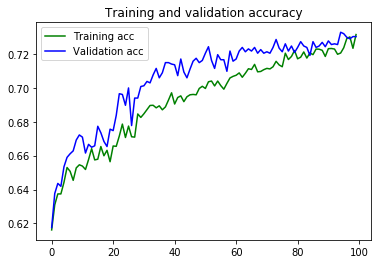

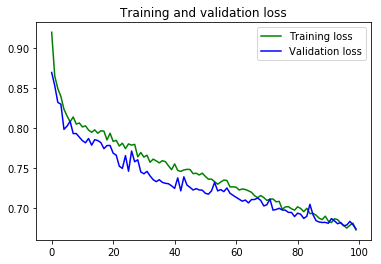

In [27]:
# Plot train/test loss and accuracy
acc = hist_1.history['acc']
val_acc = hist_1.history['val_acc']
loss = hist_1.history['loss']
val_loss = hist_1.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [32]:
# Confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

In [81]:
# Get predicted values
y_pred = lstm_mod1.predict(X_test)  # outputs probabilities of each sentiment
# Create empty numpy array to match length of training observations
y_pred_array = np.zeros(X_test.shape[0])

# Find class with highest probability
for i in range(0, y_pred.shape[0]):
    label_predict = np.argmax(y_pred[i]) # column with max probability
    y_pred_array[i] = label_predict

# convert to integers
y_pred_array = y_pred_array.astype(int)

In [82]:
# Convert y_test to 1d numpy array
y_test_array = np.zeros(X_test.shape[0])

# Find class with 1
for i in range(0, y_test.shape[0]):
    label_predict = np.argmax(y_test[i])
    y_test_array[i] = label_predict

y_test_array = y_test_array.astype(int)

In [89]:
class_names = np.array(['Negative', 'Neutral', 'Positive'])

Confusion matrix, without normalization
[[1679  160   31]
 [ 313  274   27]
 [ 166   85  193]]
Normalized confusion matrix
[[0.9  0.09 0.02]
 [0.51 0.45 0.04]
 [0.37 0.19 0.43]]


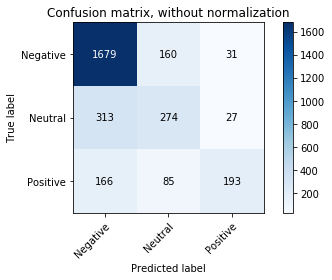

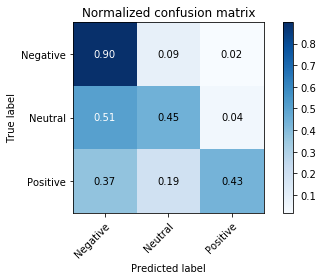

In [91]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test_array, y_pred_array, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test_array, y_pred_array, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

### Model 2: LSTM with regularization, reduce dimensionality

In [28]:
lstm_mod2 = Sequential()
lstm_mod2.add(embedding_layer)
lstm_mod2.add(LSTM(64, 
               dropout = 0.2, 
               recurrent_dropout = 0.5))
lstm_mod2.add(Dense(3, activation='softmax'))
lstm_mod2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
lstm_mod2.summary()

W0505 23:37:45.851815 140592878614336 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x7fdc7406bcf8>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 30, 100)           1576900   
_________________________________________________________________
unified_lstm_1 (UnifiedLSTM) (None, 64)                42240     
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 195       
Total params: 1,619,335
Trainable params: 42,435
Non-trainable params: 1,576,900
_________________________________________________________________


In [29]:
hist_2 = lstm_mod2.fit(X_train, y_train,
                    validation_split = 0.2,
                    epochs=100, batch_size=256)

Train on 9369 samples, validate on 2343 samples
Epoch 1/100
9369/9369 [==============================] - 5s 502us/sample - loss: 0.9683 - acc: 0.6240 - val_loss: 0.9199 - val_acc: 0.6176
Epoch 2/100
9369/9369 [==============================] - 3s 358us/sample - loss: 0.8973 - acc: 0.6230 - val_loss: 0.8724 - val_acc: 0.6176
Epoch 3/100
9369/9369 [==============================] - 3s 359us/sample - loss: 0.8722 - acc: 0.6239 - val_loss: 0.8601 - val_acc: 0.6274
Epoch 4/100
9369/9369 [==============================] - 3s 359us/sample - loss: 0.8631 - acc: 0.6311 - val_loss: 0.8644 - val_acc: 0.6248
Epoch 5/100
9369/9369 [==============================] - 3s 359us/sample - loss: 0.8620 - acc: 0.6310 - val_loss: 0.8545 - val_acc: 0.6381
Epoch 6/100
9369/9369 [==============================] - 3s 358us/sample - loss: 0.8575 - acc: 0.6328 - val_loss: 0.8545 - val_acc: 0.6355
Epoch 7/100
9369/9369 [==============================] - 3s 359us/sample - loss: 0.8577 - acc: 0.6323 - val_loss: 0.85

9369/9369 [==============================] - 3s 359us/sample - loss: 0.7512 - acc: 0.6887 - val_loss: 0.7508 - val_acc: 0.7081
Epoch 60/100
9369/9369 [==============================] - 3s 359us/sample - loss: 0.7383 - acc: 0.7032 - val_loss: 0.7514 - val_acc: 0.7102
Epoch 61/100
9369/9369 [==============================] - 3s 359us/sample - loss: 0.7435 - acc: 0.6955 - val_loss: 0.7533 - val_acc: 0.7047
Epoch 62/100
9369/9369 [==============================] - 3s 360us/sample - loss: 0.7402 - acc: 0.6979 - val_loss: 0.7490 - val_acc: 0.7008
Epoch 63/100
9369/9369 [==============================] - 3s 358us/sample - loss: 0.7376 - acc: 0.6946 - val_loss: 0.7413 - val_acc: 0.7157
Epoch 64/100
9369/9369 [==============================] - 3s 359us/sample - loss: 0.7445 - acc: 0.6935 - val_loss: 0.7422 - val_acc: 0.7051
Epoch 65/100
9369/9369 [==============================] - 3s 359us/sample - loss: 0.7305 - acc: 0.7019 - val_loss: 0.7486 - val_acc: 0.7025
Epoch 66/100
9369/9369 [=========

In [30]:
# Find train and test accuracy
loss, accuracy = lstm_mod2.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = lstm_mod2.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.7155
Testing Accuracy:  0.7138


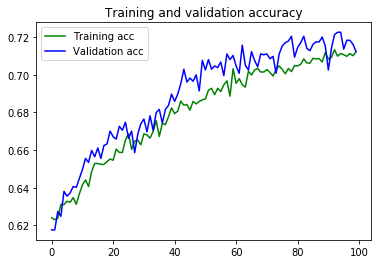

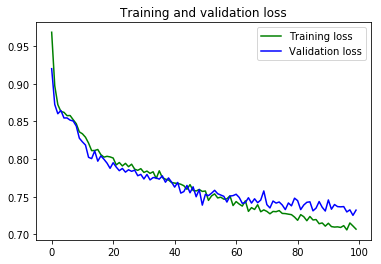

In [31]:
# Plot train/test loss and accuracy
acc = hist_2.history['acc']
val_acc = hist_2.history['val_acc']
loss = hist_2.history['loss']
val_loss = hist_2.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [92]:
# Get predicted values
y_pred = lstm_mod2.predict(X_test)  # outputs probabilities of each sentiment
# Create empty numpy array to match length of training observations
y_pred_array = np.zeros(X_test.shape[0])

# Find class with highest probability
for i in range(0, y_pred.shape[0]):
    label_predict = np.argmax(y_pred[i]) # column with max probability
    y_pred_array[i] = label_predict

# convert to integers
y_pred_array = y_pred_array.astype(int)

Confusion matrix, without normalization
[[1732  129    9]
 [ 355  242   17]
 [ 240   88  116]]
Normalized confusion matrix
[[0.93 0.07 0.  ]
 [0.58 0.39 0.03]
 [0.54 0.2  0.26]]


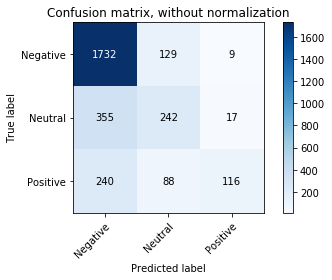

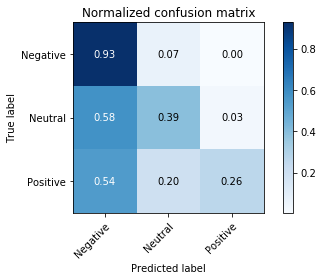

In [93]:
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test_array, y_pred_array, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test_array, y_pred_array, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

### Model 3: LSTM Layer Stacking

In [94]:
# LSTM Model
model_3 = Sequential()
model_3.add(embedding_layer)
model_3.add(LSTM(256, 
               dropout = 0.2, 
               recurrent_dropout = 0.5,
                 return_sequences = True))
model_3.add(LSTM(128,
                dropout = 0.2,
                recurrent_dropout = 0.5))
model_3.add(Dense(3, activation='softmax'))
model_3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

W0506 00:18:17.488390 140592878614336 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x7fdc49810198>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.
W0506 00:18:17.805446 140592878614336 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x7fdc49809d68>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.


In [95]:
model_3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 30, 100)           1576900   
_________________________________________________________________
unified_lstm_2 (UnifiedLSTM) (None, 30, 256)           365568    
_________________________________________________________________
unified_lstm_3 (UnifiedLSTM) (None, 128)               197120    
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 387       
Total params: 2,139,975
Trainable params: 563,075
Non-trainable params: 1,576,900
_________________________________________________________________


In [96]:
history_3 = model_3.fit(X_train, y_train,
                    validation_split = 0.2,
                    epochs=100, batch_size=256)

Train on 9369 samples, validate on 2343 samples
Epoch 1/100
9369/9369 [==============================] - 10s 1ms/sample - loss: 0.9077 - acc: 0.6179 - val_loss: 0.8545 - val_acc: 0.6308
Epoch 2/100
9369/9369 [==============================] - 8s 814us/sample - loss: 0.8532 - acc: 0.6308 - val_loss: 0.8417 - val_acc: 0.6308
Epoch 3/100
9369/9369 [==============================] - 8s 802us/sample - loss: 0.8264 - acc: 0.6439 - val_loss: 0.7925 - val_acc: 0.6598
Epoch 4/100
9369/9369 [==============================] - 8s 805us/sample - loss: 0.8070 - acc: 0.6541 - val_loss: 0.7904 - val_acc: 0.6611
Epoch 5/100
9369/9369 [==============================] - 8s 806us/sample - loss: 0.8025 - acc: 0.6564 - val_loss: 0.7839 - val_acc: 0.6607
Epoch 6/100
9369/9369 [==============================] - 8s 803us/sample - loss: 0.8035 - acc: 0.6489 - val_loss: 0.7750 - val_acc: 0.6748
Epoch 7/100
9369/9369 [==============================] - 8s 803us/sample - loss: 0.8014 - acc: 0.6531 - val_loss: 0.795

9369/9369 [==============================] - 8s 804us/sample - loss: 0.7078 - acc: 0.7129 - val_loss: 0.6939 - val_acc: 0.7222
Epoch 60/100
9369/9369 [==============================] - 8s 806us/sample - loss: 0.7085 - acc: 0.7112 - val_loss: 0.7079 - val_acc: 0.7179
Epoch 61/100
9369/9369 [==============================] - 8s 811us/sample - loss: 0.7159 - acc: 0.7054 - val_loss: 0.6875 - val_acc: 0.7298
Epoch 62/100
9369/9369 [==============================] - 8s 806us/sample - loss: 0.7025 - acc: 0.7120 - val_loss: 0.6917 - val_acc: 0.7273
Epoch 63/100
9369/9369 [==============================] - 8s 805us/sample - loss: 0.6988 - acc: 0.7141 - val_loss: 0.6834 - val_acc: 0.7281
Epoch 64/100
9369/9369 [==============================] - 8s 803us/sample - loss: 0.6985 - acc: 0.7142 - val_loss: 0.6871 - val_acc: 0.7281
Epoch 65/100
9369/9369 [==============================] - 8s 803us/sample - loss: 0.6934 - acc: 0.7221 - val_loss: 0.6842 - val_acc: 0.7277
Epoch 66/100
9369/9369 [=========

In [97]:
# Find train and test accuracy
loss, accuracy = model_3.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model_3.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.7563
Testing Accuracy:  0.7394


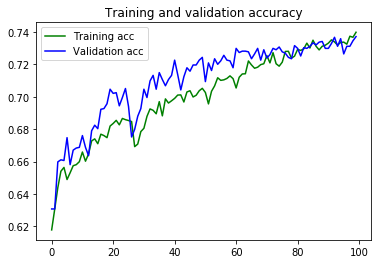

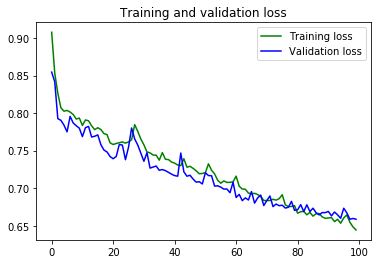

In [98]:
# Plot train/test loss and accuracy
acc = history_3.history['acc']
val_acc = history_3.history['val_acc']
loss = history_3.history['loss']
val_loss = history_3.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [99]:
# Get predicted values
y_pred = model_3.predict(X_test)  # outputs probabilities of each sentiment
# Create empty numpy array to match length of training observations
y_pred_array = np.zeros(X_test.shape[0])

# Find class with highest probability
for i in range(0, y_pred.shape[0]):
    label_predict = np.argmax(y_pred[i]) # column with max probability
    y_pred_array[i] = label_predict

# convert to integers
y_pred_array = y_pred_array.astype(int)

Confusion matrix, without normalization
[[1688  148   34]
 [ 298  284   32]
 [ 175   76  193]]
Normalized confusion matrix
[[0.9  0.08 0.02]
 [0.49 0.46 0.05]
 [0.39 0.17 0.43]]


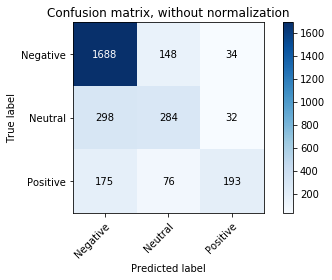

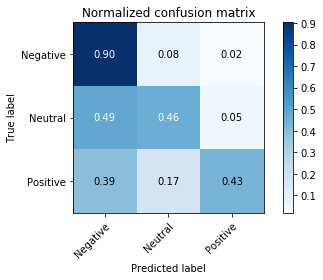

In [100]:
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test_array, y_pred_array, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test_array, y_pred_array, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

### Model 4: GRU Layer Stacking

In [101]:
# GRU Model 2: reduce number of epochs
model_4 = Sequential()
model_4.add(embedding_layer)
model_4.add(GRU(256, 
               dropout = 0.2, 
               recurrent_dropout = 0.5,
                 return_sequences = True))
model_4.add(GRU(128,
                dropout = 0.2,
                recurrent_dropout = 0.5))
model_4.add(Dense(3, activation='softmax'))
model_4.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

In [102]:
model_4.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 30, 100)           1576900   
_________________________________________________________________
unified_gru (UnifiedGRU)     (None, 30, 256)           274944    
_________________________________________________________________
unified_gru_1 (UnifiedGRU)   (None, 128)               148224    
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 387       
Total params: 2,000,455
Trainable params: 423,555
Non-trainable params: 1,576,900
_________________________________________________________________


In [103]:
history_4 = model_4.fit(X_train, y_train,
                    validation_split = 0.2,
                    epochs=100, batch_size=256)

Train on 9369 samples, validate on 2343 samples
Epoch 1/100
9369/9369 [==============================] - 9s 1ms/sample - loss: 0.9398 - acc: 0.6116 - val_loss: 0.9102 - val_acc: 0.6176
Epoch 2/100
9369/9369 [==============================] - 7s 766us/sample - loss: 0.8837 - acc: 0.6234 - val_loss: 0.8638 - val_acc: 0.6347
Epoch 3/100
9369/9369 [==============================] - 7s 767us/sample - loss: 0.8597 - acc: 0.6327 - val_loss: 0.8663 - val_acc: 0.6210
Epoch 4/100
9369/9369 [==============================] - 7s 770us/sample - loss: 0.8525 - acc: 0.6348 - val_loss: 0.8481 - val_acc: 0.6351
Epoch 5/100
9369/9369 [==============================] - 7s 777us/sample - loss: 0.8473 - acc: 0.6334 - val_loss: 0.8387 - val_acc: 0.6317
Epoch 6/100
9369/9369 [==============================] - 7s 776us/sample - loss: 0.8300 - acc: 0.6413 - val_loss: 0.8111 - val_acc: 0.6590
Epoch 7/100
9369/9369 [==============================] - 7s 766us/sample - loss: 0.8135 - acc: 0.6498 - val_loss: 0.7942

9369/9369 [==============================] - 7s 766us/sample - loss: 0.6263 - acc: 0.7501 - val_loss: 0.6412 - val_acc: 0.7388
Epoch 60/100
9369/9369 [==============================] - 7s 770us/sample - loss: 0.6278 - acc: 0.7452 - val_loss: 0.6434 - val_acc: 0.7397
Epoch 61/100
9369/9369 [==============================] - 7s 767us/sample - loss: 0.6273 - acc: 0.7452 - val_loss: 0.6415 - val_acc: 0.7452
Epoch 62/100
9369/9369 [==============================] - 7s 767us/sample - loss: 0.6160 - acc: 0.7516 - val_loss: 0.6318 - val_acc: 0.7435
Epoch 63/100
9369/9369 [==============================] - 7s 770us/sample - loss: 0.6180 - acc: 0.7482 - val_loss: 0.6340 - val_acc: 0.7418
Epoch 64/100
9369/9369 [==============================] - 7s 767us/sample - loss: 0.6143 - acc: 0.7505 - val_loss: 0.6278 - val_acc: 0.7482
Epoch 65/100
9369/9369 [==============================] - 7s 766us/sample - loss: 0.6054 - acc: 0.7575 - val_loss: 0.6285 - val_acc: 0.7495
Epoch 66/100
9369/9369 [=========

In [104]:
loss, accuracy = model_4.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model_4.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.8064
Testing Accuracy:  0.7551


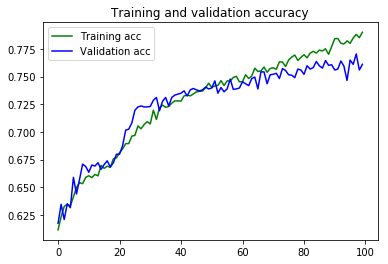

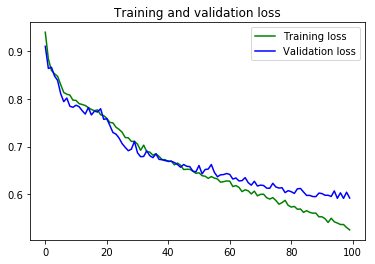

In [105]:
acc = history_4.history['acc']
val_acc = history_4.history['val_acc']
loss = history_4.history['loss']
val_loss = history_4.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [106]:
# Get predicted values
y_pred = model_4.predict(X_test)  # outputs probabilities of each sentiment
# Create empty numpy array to match length of training observations
y_pred_array = np.zeros(X_test.shape[0])

# Find class with highest probability
for i in range(0, y_pred.shape[0]):
    label_predict = np.argmax(y_pred[i]) # column with max probability
    y_pred_array[i] = label_predict

# convert to integers
y_pred_array = y_pred_array.astype(int)

Confusion matrix, without normalization
[[1634  165   71]
 [ 238  325   51]
 [ 117   75  252]]
Normalized confusion matrix
[[0.87 0.09 0.04]
 [0.39 0.53 0.08]
 [0.26 0.17 0.57]]


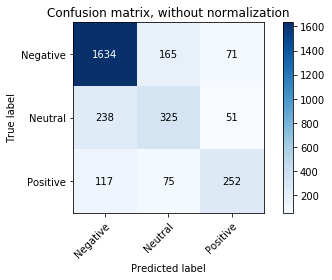

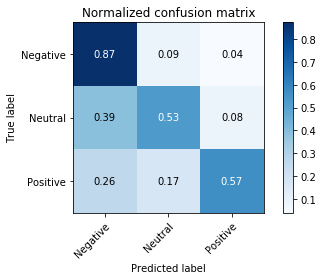

In [107]:
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test_array, y_pred_array, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test_array, y_pred_array, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

### Model 5: Reduced GRU with More Regularization

In [108]:
model_5 = Sequential()
model_5.add(embedding_layer)
model_5.add(GRU(64, 
               dropout = 0.3, 
               recurrent_dropout = 0.5,
                 return_sequences = True))
model_5.add(GRU(32,
                dropout = 0.2,
                recurrent_dropout = 0.5))
model_5.add(Dense(3, activation='softmax'))
model_5.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

In [109]:
model_5.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 30, 100)           1576900   
_________________________________________________________________
unified_gru_2 (UnifiedGRU)   (None, 30, 64)            31872     
_________________________________________________________________
unified_gru_3 (UnifiedGRU)   (None, 32)                9408      
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 99        
Total params: 1,618,279
Trainable params: 41,379
Non-trainable params: 1,576,900
_________________________________________________________________


In [110]:
history_5 = model_5.fit(X_train, y_train,
                    validation_split = 0.2,
                    epochs=100, batch_size=256)

Train on 9369 samples, validate on 2343 samples
Epoch 1/100
9369/9369 [==============================] - 9s 993us/sample - loss: 0.9665 - acc: 0.6146 - val_loss: 0.9342 - val_acc: 0.6176
Epoch 2/100
9369/9369 [==============================] - 7s 724us/sample - loss: 0.9223 - acc: 0.6256 - val_loss: 0.9197 - val_acc: 0.6176
Epoch 3/100
9369/9369 [==============================] - 7s 723us/sample - loss: 0.8895 - acc: 0.6254 - val_loss: 0.8680 - val_acc: 0.6176
Epoch 4/100
9369/9369 [==============================] - 7s 724us/sample - loss: 0.8686 - acc: 0.6293 - val_loss: 0.8557 - val_acc: 0.6342
Epoch 5/100
9369/9369 [==============================] - 7s 732us/sample - loss: 0.8622 - acc: 0.6304 - val_loss: 0.8558 - val_acc: 0.6325
Epoch 6/100
9369/9369 [==============================] - 7s 731us/sample - loss: 0.8580 - acc: 0.6302 - val_loss: 0.8540 - val_acc: 0.6398
Epoch 7/100
9369/9369 [==============================] - 7s 735us/sample - loss: 0.8539 - acc: 0.6329 - val_loss: 0.85

9369/9369 [==============================] - 7s 724us/sample - loss: 0.7116 - acc: 0.7072 - val_loss: 0.6858 - val_acc: 0.7264
Epoch 60/100
9369/9369 [==============================] - 7s 725us/sample - loss: 0.7084 - acc: 0.7109 - val_loss: 0.6896 - val_acc: 0.7239
Epoch 61/100
9369/9369 [==============================] - 7s 724us/sample - loss: 0.7132 - acc: 0.7073 - val_loss: 0.6838 - val_acc: 0.7290
Epoch 62/100
9369/9369 [==============================] - 7s 725us/sample - loss: 0.7073 - acc: 0.7143 - val_loss: 0.6811 - val_acc: 0.7324
Epoch 63/100
9369/9369 [==============================] - 7s 724us/sample - loss: 0.7045 - acc: 0.7110 - val_loss: 0.6893 - val_acc: 0.7264
Epoch 64/100
9369/9369 [==============================] - 7s 723us/sample - loss: 0.7016 - acc: 0.7146 - val_loss: 0.6816 - val_acc: 0.7315
Epoch 65/100
9369/9369 [==============================] - 7s 724us/sample - loss: 0.6996 - acc: 0.7177 - val_loss: 0.6770 - val_acc: 0.7328
Epoch 66/100
9369/9369 [=========

In [111]:
loss, accuracy = model_5.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model_5.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.7543
Testing Accuracy:  0.7387


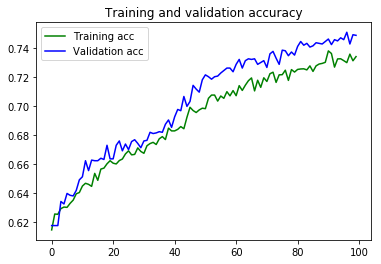

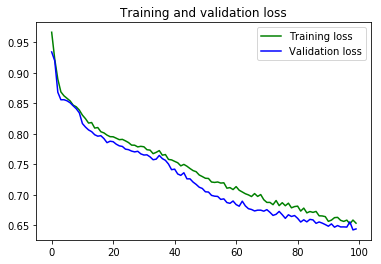

In [112]:
acc = history_5.history['acc']
val_acc = history_5.history['val_acc']
loss = history_5.history['loss']
val_loss = history_5.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [113]:
# Get predicted values
y_pred = model_5.predict(X_test)  # outputs probabilities of each sentiment
# Create empty numpy array to match length of training observations
y_pred_array = np.zeros(X_test.shape[0])

# Find class with highest probability
for i in range(0, y_pred.shape[0]):
    label_predict = np.argmax(y_pred[i]) # column with max probability
    y_pred_array[i] = label_predict

# convert to integers
y_pred_array = y_pred_array.astype(int)

Confusion matrix, without normalization
[[1685  152   33]
 [ 310  273   31]
 [ 154   85  205]]
Normalized confusion matrix
[[0.9  0.08 0.02]
 [0.5  0.44 0.05]
 [0.35 0.19 0.46]]


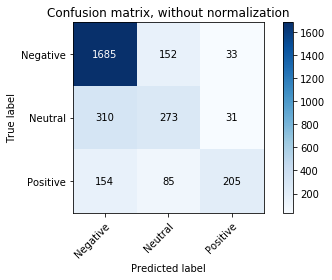

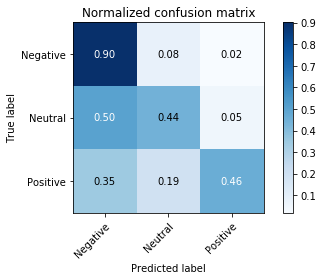

In [114]:
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test_array, y_pred_array, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test_array, y_pred_array, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

### Model 6: Bidirectional RNN

In [115]:
from tensorflow.keras.layers import Bidirectional

In [116]:
# Bidirectional RNNs
model_6 = Sequential()
model_6.add(embedding_layer)
model_6.add(Bidirectional(LSTM(64)))
model_6.add(Dense(3,activation='softmax'))
model_6.summary()

W0506 01:06:39.660960 140592878614336 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x7fdb2c7cd198>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.
W0506 01:06:39.666084 140592878614336 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x7fdb2c780dd8>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 30, 100)           1576900   
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               84480     
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 387       
Total params: 1,661,767
Trainable params: 84,867
Non-trainable params: 1,576,900
_________________________________________________________________


In [117]:
model_6.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

In [118]:
history_6 = model_6.fit(X_train, y_train,
                    validation_split = 0.2,
                    epochs=50, batch_size=256)

Train on 9369 samples, validate on 2343 samples
Epoch 1/50
9369/9369 [==============================] - 4s 442us/sample - loss: 0.9345 - acc: 0.6286 - val_loss: 0.8644 - val_acc: 0.6176
Epoch 2/50
9369/9369 [==============================] - 0s 25us/sample - loss: 0.8411 - acc: 0.6355 - val_loss: 0.8419 - val_acc: 0.6406
Epoch 3/50
9369/9369 [==============================] - 0s 25us/sample - loss: 0.8264 - acc: 0.6408 - val_loss: 0.8318 - val_acc: 0.6364
Epoch 4/50
9369/9369 [==============================] - 0s 25us/sample - loss: 0.8148 - acc: 0.6460 - val_loss: 0.8294 - val_acc: 0.6411
Epoch 5/50
9369/9369 [==============================] - 0s 25us/sample - loss: 0.8010 - acc: 0.6524 - val_loss: 0.8082 - val_acc: 0.6487
Epoch 6/50
9369/9369 [==============================] - 0s 24us/sample - loss: 0.7924 - acc: 0.6631 - val_loss: 0.7944 - val_acc: 0.6624
Epoch 7/50
9369/9369 [==============================] - 0s 25us/sample - loss: 0.7750 - acc: 0.6645 - val_loss: 0.7883 - val_acc:

In [119]:
loss, accuracy = model_6.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model_6.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.7594
Testing Accuracy:  0.7155


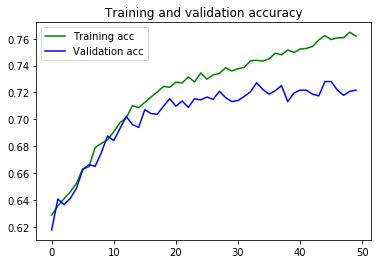

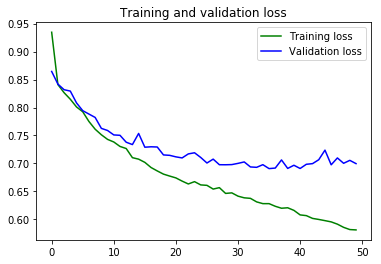

In [120]:
acc = history_6.history['acc']
val_acc = history_6.history['val_acc']
loss = history_6.history['loss']
val_loss = history_6.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [121]:
# Get predicted values
y_pred = model_6.predict(X_test)  # outputs probabilities of each sentiment
# Create empty numpy array to match length of training observations
y_pred_array = np.zeros(X_test.shape[0])

# Find class with highest probability
for i in range(0, y_pred.shape[0]):
    label_predict = np.argmax(y_pred[i]) # column with max probability
    y_pred_array[i] = label_predict

# convert to integers
y_pred_array = y_pred_array.astype(int)

Confusion matrix, without normalization
[[1593  189   88]
 [ 267  290   57]
 [ 144   88  212]]
Normalized confusion matrix
[[0.85 0.1  0.05]
 [0.43 0.47 0.09]
 [0.32 0.2  0.48]]


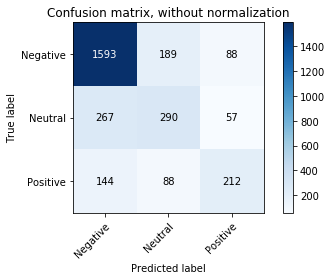

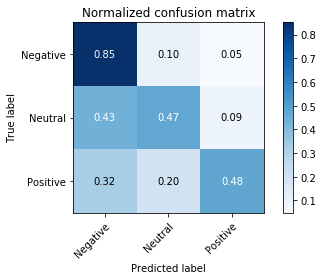

In [122]:
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test_array, y_pred_array, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test_array, y_pred_array, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

## References

https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html<br>
https://realpython.com/python-keras-text-classification/<br>
https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/<br>
https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html